In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr

# Inputs

external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories

def test_correlation(df, x_array, y_array, corrType):
    
    store_array = []
    
    for item_x in x_array:
        for item_y in y_array:
            score, pval = corrType(df[item_x],df[item_y])
            store_array.append([item_x, item_y, score,pval])
            
    df = pd.DataFrame(store_array,columns=['x','y','Correlation','P Value'])
            
    return df


In [3]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['student_activity'] =  (df.filter(regex='_cor_std').sum(axis=1)/(df.filter(regex='Entries').sum(axis=1))).fillna(0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Set all external indices with no value as NULL
df['IDACI'] = df['IDACI'].replace(to_replace=0,value=np.nan)
df['L_M_index'] = df['L_M_index'].replace(to_replace=0,value=np.nan)
df['Effectiveness'] = df['Effectiveness'].replace(to_replace=0,value=np.nan)
df['Teach_quality'] = df['Teach_quality'].replace(to_replace=0,value=np.nan)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

# Binning according to IP activity
bins = [-0.1, 0, 10,1000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'student_activity',bins,group_names)

# Creating another dataframe that has removed outliers (who fall outside the 95% percentile)
q = df[['student_activity']].quantile(0.95)
df_out = df[(df[q.keys()] < q).all(axis=1)]

print(df_out.shape)
df_out.head()

(854, 56)


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,q_lvl_2_cor_tch,view_concept_tch,q_lvl_3_cor_tch,q_lvl_2_tch,q_lvl_0_cor_tch,...,exam_improv_2013-2014_Biology,exam_improv_2013-2014_Mathematics,exam_improv_2013-2014_Chemistry,exam_improv_2013-2014_Physics,exam_improv_2013-2016_Biology,exam_improv_2013-2016_Mathematics,exam_improv_2013-2016_Chemistry,exam_improv_2013-2016_Physics,student_activity,categories
URN,,,,,,,,,,,,,,,,,,,,,
100001,NaN,NaN,NaN,NaN,0.0,0.0,3.0,0.0,0.0,0.0,...,0.036272,-0.003697,-0.061495,-0.099692,0.029736,-0.043330,-0.003100,-0.062738,0.817043,Semi-active
100003,NaN,NaN,NaN,NaN,0.0,0.0,8.0,0.0,0.0,29.0,...,-0.080350,-0.020661,-0.019674,0.052747,-0.020112,-0.013455,-0.009502,0.106763,3.008000,Semi-active
100054,5.0,1.0,1.0,1.0,19.7,1.0,8.0,1.0,3.0,0.0,...,0.138762,-0.006687,0.016362,0.015041,-0.035131,-0.017300,0.003301,-0.038957,1.004464,Semi-active
100065,NaN,NaN,NaN,NaN,0.0,8.0,10.0,12.0,49.0,44.0,...,0.096233,0.001924,0.015242,0.059983,0.064762,-0.037641,0.037853,0.113732,3.835866,Semi-active
100076,NaN,NaN,NaN,NaN,0.0,22.0,2.0,35.0,78.0,0.0,...,-0.107807,0.032783,-0.044749,-0.167057,-0.109535,-0.023395,-0.024589,-0.062783,0.079470,Semi-active


(array([ 341.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  297.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  227.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   24.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   10.]),
 array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
         0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,
         0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ,  1.0

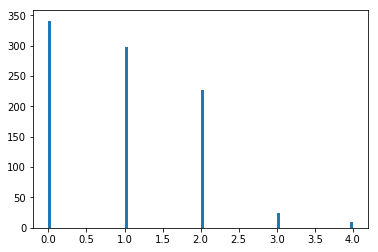

In [16]:
plt.hist(df['Effectiveness'].fillna(0),100)
#plt.ylim([0,50])

In [4]:
df[df['categories']=='Active'].corr()[['IDACI','Effectiveness','Teach_quality','L_M_index']]



,IDACI,Effectiveness,Teach_quality,L_M_index
IDACI,1.000000,-0.275644,0.103366,-0.189505
Effectiveness,-0.275644,1.000000,0.842105,0.868421
Teach_quality,0.103366,0.842105,1.000000,0.842105
L_M_index,-0.189505,0.868421,0.842105,1.000000
PercentageFSM,0.553097,0.338035,0.516879,0.256147
q_lvl_2_cor_tch,-0.139078,-0.013379,-0.041354,0.029191
view_concept_tch,0.129408,-0.323465,-0.357514,-0.280904
q_lvl_3_cor_tch,0.576290,-0.251514,0.012576,-0.188635
q_lvl_2_tch,-0.131441,-0.049268,-0.117607,-0.081054
q_lvl_0_cor_tch,-0.034151,-0.182608,-0.225567,-0.161889


In [18]:
df[df['categories']=='Inactive'].corr()['exam_improv_2013-2016_Physics'].sort_values(ascending=False)

exam_improv_2013-2016_Physics        1.000000
exam_improv_2013-2014_Physics        0.463375
exam_improv_2013-2016_Mathematics    0.414300
exam_improv_2013-2016_Chemistry      0.335616
exam_improv_2013-2016_Biology        0.261938
exam_improv_2013-2014_Biology        0.144436
exam_improv_2013-2014_Chemistry      0.143089
exam_improv_2013-2014_Mathematics    0.128298
q_lvl_2_cor_tch                      0.069370
q_lvl_5_tch                          0.063668
q_lvl_0_cor_tch                      0.062113
q_lvl_5_cor_tch                      0.061382
view_assig_prog                      0.052887
q_lvl_2_tch                          0.044809
play_video_tch                       0.038195
view_hint_tch                        0.036796
view_concept_tch                     0.035715
user_id_tch                          0.026369
add_custom_assig                     0.025414
q_lvl_0_tch                          0.025224
add_user                             0.024376
q_lvl_6_cor_tch                   